Dataset shape: (10479, 6)
Agglomerative Clustering Silhouette Score: 0.3546012742037838


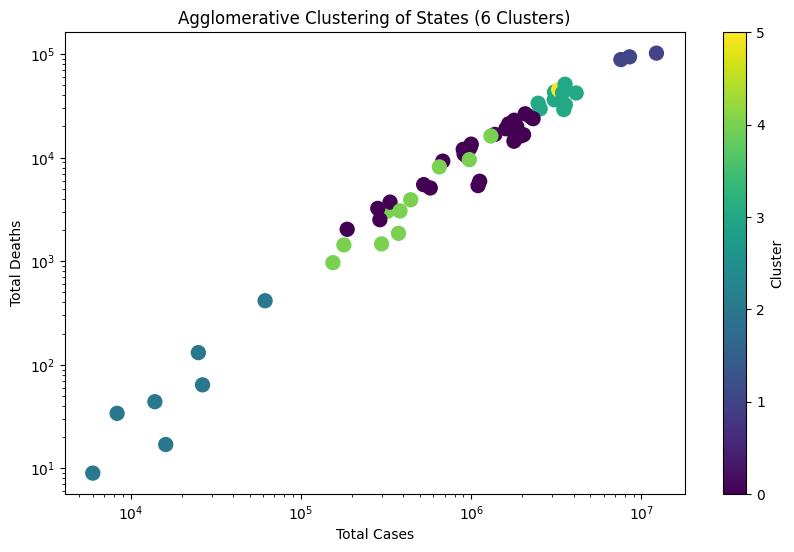

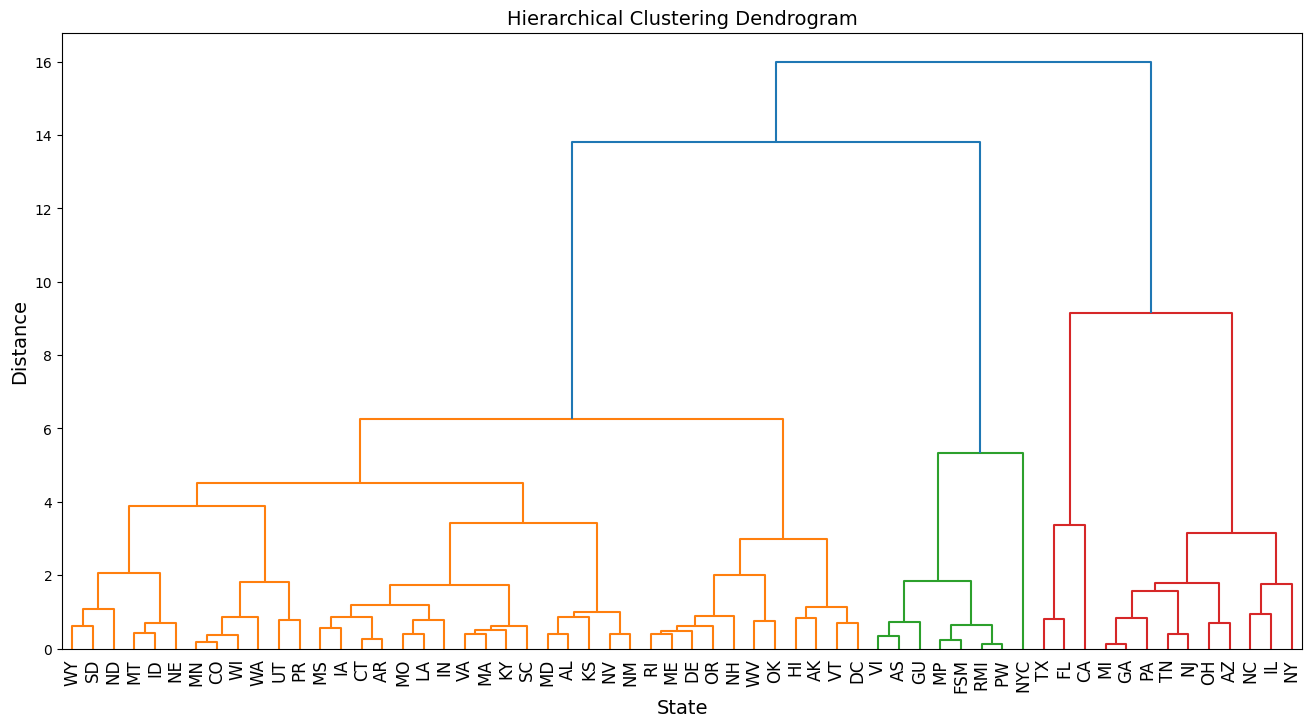

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

covid_data = pd.read_csv("death_sero.csv")
print("Dataset shape:", covid_data.shape)


# Create state-level aggregates
state_aggregates = covid_data.groupby('state').agg({
    'tot_cases': 'max',
    'tot_deaths': 'max', 
    'n_samples': 'mean',
    'n_infected': 'mean'
}).reset_index()

# Fill NaN values with 0 for clustering
state_aggregates = state_aggregates.fillna(0)

# Create additional features
state_aggregates['case_fatality_rate'] = np.where(
    state_aggregates['tot_cases'] > 0, 
    state_aggregates['tot_deaths'] / state_aggregates['tot_cases'], 
    0
)

state_aggregates['infection_rate'] = np.where(
    state_aggregates['n_samples'] > 0,
    state_aggregates['n_infected'] / state_aggregates['n_samples'],
    0
)

# Select features for clustering
covid_related = state_aggregates[[
    'tot_cases',
    'tot_deaths', 
    'case_fatality_rate',
    'n_samples',
    'n_infected',
    'infection_rate'
]]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(covid_related)

model = AgglomerativeClustering(n_clusters=6)
model.fit(scaled_features)

labels = model.labels_  

# Scatterplot
x = covid_related['tot_cases']
y = covid_related['tot_deaths']

plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=labels, cmap='viridis', s=100)

plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.title('Agglomerative Clustering of States (6 Clusters)')
plt.colorbar(label='Cluster')
plt.xscale('log')
plt.yscale('log')

# dendrogram
linked = linkage(scaled_features, method='ward')

plt.figure(figsize=(16, 8))
dendrogram(linked,
           labels=state_aggregates['state'].values,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_font_size=12)

plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.xticks(rotation=90)

# Calculate silhouette score
score = silhouette_score(scaled_features, labels)
print("Agglomerative Clustering Silhouette Score:", score)

